## problem statement
![](http://www.beheadingboredom.com/wp-content/uploads/2014/10/bad-joke-eel-restaurant-moon.jpg)

During the upcoming weekends we will have some time to visit the city of Boston and explore the culinary scene. But Boston has so many restaurants to choose from that it's very hard to decide on where to go and what to eat.
![](./problem_statement.png)

# Solution
Let's use some data science to figure out the best possible restaurant for your taste. 

## steps
* identify all boston restaurants
* some curation ahead (we can only due minor curation in the interest of time) 
 * standardize restaurant names
 * get missing geo locations through geopy
* get customer ratings and pricing information from yelp
* get hygienic data from analyze boston
* get crime incident data from analyze boston
* calculate a local criminal attack probability
* fuse all data and rank the restaurants using lineup
* plot the top 10 candidates on a map

## excercises
some ideas (to select from)
* who owns most restaurants?
* which is the chain with the most restaurants
* which restaurant had the most hygenic incidents
* what is the oldest restaurants
* who serves the most exotic food
* which is the restaurant with the most criminal incidents
* are there 'criminal hotspots'?
* what is the area with the most appraised restaurants?

## install some libs

In [4]:
!pip install yelpapi --user
!pip install folium
!pip install geopy
!pip install autocorrect
!pip install python-Levenshtein

## imports

In [1]:
import pandas as pd # dataframes for python. see http://pandas.pydata.org/
import seaborn as sns # visualization lib. see https://seaborn.pydata.org/
from yelpapi import YelpAPI # web service API from yelp. see https://github.com/gfairchild/yelpapi
from geopy.geocoders import Nominatim # library to convert adress into geolocation
from Levenshtein import ratio
import itertools
from ipywidgets import FloatProgress
from IPython.display import display
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## get all restaurants from boston analytics file
check https://data.boston.gov/ there is more data to play with

In [5]:
restaurants = pd.read_csv('../data/licenses.csv')

In [7]:
# make columns lower case (my personal preference)
restaurants.columns = [ele.lower() for ele in restaurants.columns.tolist()]

In [8]:
restaurants.head()

,businessname,dbaname,address,city,state,zip,licstatus,licensecat,descript,licenseadddttm,dayphn,property_id,location
0,# 7 RESTAURANT,NaN,225 Grove,West Roxbury,MA,02132,Active,FT,Eating & Drinking w/ Take Out,2007-03-23 15:20:59,10000000000,156965.0,"(42.261873000, -71.157410000)"
1,100 Percent Delicia Food,NaN,635 Hyde Park,Roslindale,MA,02131,Active,FS,Eating & Drinking,2013-02-15 10:46:21,16174774546,77476.0,"(42.278590000, -71.119440000)"
2,1000 Degrees Pizza,NaN,55 Court,Boston,MA,02108,Active,FS,Eating & Drinking,2017-01-20 11:47:40,10000000000,156226.0,"(42.359227000, -71.058878000)"
3,125 Nashua St. Cafe (MGH),NaN,125 Nashua,Boston,MA,02114,Active,FS,Eating & Drinking,2014-08-15 13:03:32,10000000000,340055.0,"(42.367830000, -71.064950000)"
4,129 Lake Street Cafe,NaN,127 LAKE,Brighton/,MA,02135,Active,FS,Eating & Drinking,2010-10-14 12:49:26,16175523307,0.0,"(0.000000000, 0.000000000)"


### data exploration and curation

In [9]:
# all Boston?
restaurants.city.value_counts()

Boston                1378
BOSTON                 255
Dorchester             200
East Boston            147
Roxbury                139
Brighton               116
Allston                113
Jamaica Plain           87
South Boston            83
EAST BOSTON             55
Roslindale              54
West Roxbury            47
DORCHESTER              40
Charlestown             37
Hyde Park               30
Mission Hill            27
ALLSTON                 27
Mattapan                25
BRIGHTON                20
SOUTH BOSTON            18
ROXBURY                 11
East Boston/             8
JAMAICA PLAIN            7
MATTAPAN                 6
HYDE PARK                6
WEST ROXBURY             6
Financial District       5
ROSLINDALE               5
CHARLESTOWN              3
                         2
Charlestown/             2
South Boston/            2
Fenway/                  2
Boston/                  2
Mattapan/                1
Chestnut Hill            1
roxbury                  1
C

In [10]:
# remove everything which does not contain boston
restaurants = restaurants.loc[restaurants.city.str.contains('(?i)boston'),:]
# standardize (just for completeness)
restaurants['city'] = 'Boston'

In [11]:
#check
restaurants.city.value_counts()

Boston    1950
Name: city, dtype: int64

In [43]:
# reset index
restaurants = restaurants.reset_index(drop = True)

In [44]:
# all adresses plausible?
restaurants.address.value_counts()

4 Yawkey                       57
100 Legends                    54
300 Terminal                   21
200 Logan Airport Trmnl B      21
800 Boylston                   17
200 Faneuil Hall Market        15
500 Terminal                   12
417 Washington                 12
415 Summer                     10
8 Park                         10
200 Terminal                   10
100 Hanover                    10
100 Logan Airport Trmnl A       9
300 Faneuil Hall Market         9
640 Atlantic                    9
300 Logan Airport Trmnl C       9
100-199 Faneuil Hall Market     7
700 Atlantic                    7
100 Terminal                    6
99 Seaport                      6
155 Seaport                     5
200 Seaport                     5
1 Faneuil Hall Mkt Pl           5
40 Harrison                     5
350 Longwood                    5
1 Federal                       5
606 Congress                    5
31 Saint James                  5
131 Dartmouth                   4
55 Fruit      

In [19]:
# YAWKEY vs Yawkey is something we don't like, right?
restaurants['address'] = restaurants.address.str.title()

In [20]:
# better now?
restaurants.address.value_counts()

4 Yawkey                       57
100 Legends                    54
300 Terminal                   21
200 Logan Airport Trmnl B      21
800 Boylston                   17
200 Faneuil Hall Market        15
500 Terminal                   12
417 Washington                 12
415 Summer                     10
8 Park                         10
200 Terminal                   10
100 Hanover                    10
100 Logan Airport Trmnl A       9
300 Faneuil Hall Market         9
640 Atlantic                    9
300 Logan Airport Trmnl C       9
100-199 Faneuil Hall Market     7
700 Atlantic                    7
100 Terminal                    6
99 Seaport                      6
155 Seaport                     5
200 Seaport                     5
1 Faneuil Hall Mkt Pl           5
40 Harrison                     5
350 Longwood                    5
1 Federal                       5
606 Congress                    5
31 Saint James                  5
131 Dartmouth                   4
55 Fruit      

In [45]:
# 100 Legends occurs 54 times. what's wrong?
restaurants.query("address == '100 Legends'")
## google --> TD Garden, event location

,businessname,dbaname,address,city,state,zip,licstatus,licensecat,descript,licenseadddttm,dayphn,property_id,location,adress
144,Basho Japanese Brasserie,NaN,100 Legends,Boston,MA,02114,Active,FS,Eating & Drinking,2016-10-04 09:56:45,16172621338,NaN,"(0.000000000, 0.000000000)",100 Legends
472,Crazy Dough's Pizza,NaN,100 Legends,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2010-08-31 13:32:34,17819389944,NaN,"(0.000000000, 0.000000000)",100 Legends
600,Dunkin Donuts North Station,NaN,100 Legends,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2007-12-17 09:51:57,16173674301,NaN,"(0.000000000, 0.000000000)",100 Legends
650,Emack & Bolio,NaN,100 Legends,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2007-08-06 12:34:03,16175924424,NaN,"(0.000000000, 0.000000000)",100 Legends
842,Hub Bar Stand 4BE,NaN,100 Legends,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2009-02-01 11:32:55,16176241600,NaN,"(0.000000000, 0.000000000)",100 Legends
1048,Market Place West 3 - Stand #104,NaN,100 Legends,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2009-02-01 11:33:35,16176241600,NaN,"(0.000000000, 0.000000000)",100 Legends
1309,Premium Market,NaN,100 Legends,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2009-02-01 11:27:41,16176241600,NaN,"(0.000000000, 0.000000000)",100 Legends
1524,Stand # 722,NaN,100 Legends,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2009-01-27 12:03:16,16176241600,NaN,"(0.000000000, 0.000000000)",100 Legends
1525,Stand # 724,NaN,100 Legends,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2009-01-27 11:55:14,16176241600,NaN,"(0.000000000, 0.000000000)",100 Legends
1526,Stand #301,NaN,100 Legends,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2009-02-01 11:05:45,16176241600,NaN,"(0.000000000, 0.000000000)",100 Legends


In [129]:
# same geolocation but different adress --> split, apply, combine principle
restaurants.groupby('location').apply(lambda x: len(x.address.unique()))
# oops, what's wrong with (0.0000, 0.0000)
# --> no geolocation existing, but why?

location
(0.000000000, 0.000000000)       414
(42.328788000, -71.057108000)      1
(42.329690000, -71.052870000)      1
(42.329750000, -71.057390000)      1
(42.329935000, -71.056761000)      1
(42.330030000, -71.056550000)      1
(42.330089000, -71.032158000)      1
(42.330488000, -71.056730000)      1
(42.331251000, -71.041281000)      1
(42.331583000, -71.035050000)      1
(42.332022000, -71.052758000)      1
(42.332126000, -71.027028000)      1
(42.332855000, -71.051318000)      1
(42.333002000, -71.107495000)      1
(42.333370000, -71.027310000)      1
(42.333630000, -71.105490000)      1
(42.333793000, -71.105138000)      1
(42.333841000, -71.105038000)      1
(42.334030000, -71.055040000)      1
(42.334052000, -71.035091000)      1
(42.334069000, -71.105529000)      1
(42.334854000, -71.102439000)      1
(42.334979000, -71.033538000)      1
(42.334987000, -71.089493000)      1
(42.335080000, -71.057290000)      1
(42.335085000, -71.105718000)      1
(42.335135000, -71.035629000)

In [49]:
# get one example and check in google
restaurants.query("location == '(0.000000000, 0.000000000)'")
# --> 66 Harrison 20111 Boston --> 42.3511639,-71.0631901
# this should be fixable using geocoding

,businessname,dbaname,address,city,state,zip,licstatus,licensecat,descript,licenseadddttm,dayphn,property_id,location,adress
2,163 Vietnamese Sandwich,NaN,66 Harrison,Boston,MA,02111,Active,FS,Eating & Drinking,2007-08-09 13:26:45,16175427903,NaN,"(0.000000000, 0.000000000)",66 Harrison
4,300 Saratoga Cafe,NaN,300 Saratoga,Boston,MA,02128,Active,FS,Eating & Drinking,2017-03-13 10:11:32,16175670300,391711.0,"(0.000000000, 0.000000000)",300 Saratoga
10,75 On Liberty Wharf,NaN,220 Northern,Boston,MA,02210,Active,FS,Eating & Drinking,2012-05-18 10:28:35,16178547631,342823.0,"(0.000000000, 0.000000000)",220 Northern
12,A K's Take Out & Delivery@Reggie Lewis Track,NaN,1350 Tremont,Boston,MA,02116,Active,FT,Eating & Drinking w/ Take Out,2008-10-20 09:21:08,1617,NaN,"(0.000000000, 0.000000000)",1350 Tremont
15,ABIGAIL'S TEA ROOM @CONGRESS BRIDGE,NaN,306 Congress,Boston,MA,02210,Active,FS,Eating & Drinking,2012-01-17 12:47:36,16177371773,NaN,"(0.000000000, 0.000000000)",306 Congress
16,Aceituna Grill,NaN,99 Seaport,Boston,MA,02210,Active,FS,Eating & Drinking,2016-06-20 11:02:50,16172520707,350792.0,"(0.000000000, 0.000000000)",99 Seaport
20,Air France Lounge,NaN,500 Terminal,Boston,MA,02128,Active,FS,Eating & Drinking,2014-12-31 11:30:03,12016383677,341351.0,"(0.000000000, 0.000000000)",500 Terminal
25,ALGONQUIN CLUB OF BOSTON,NaN,217 Commonwealth,Boston,MA,02116,Active,FS,Eating & Drinking,2006-12-07 13:34:11,16172662400,NaN,"(0.000000000, 0.000000000)",217 Commonwealth
28,Aloft Seaport Hotel -Banquet Kitchen,NaN,401 D,Boston,MA,02210,Active,FS,Eating & Drinking,2016-01-26 13:46:43,16175324820,355423.0,"(0.000000000, 0.000000000)",401 D
29,Aloft Seaport Hotel -Re Fuel Bar,NaN,401 D,Boston,MA,02210,Active,FT,Eating & Drinking w/ Take Out,2016-01-26 13:51:26,16175324820,355423.0,"(0.000000000, 0.000000000)",401 D


In [82]:
restaurants.loc[1,:]

businessname          125 Nashua St. Cafe (MGH)
dbaname                                     NaN
address                              125 Nashua
city                                     Boston
state                                        MA
zip                                       02114
licstatus                                Active
licensecat                                   FS
descript                      Eating & Drinking
licenseadddttm              2014-08-15 13:03:32
dayphn                              10000000000
property_id                              340055
location          (42.367830000, -71.064950000)
adress                               125 Nashua
Name: 1, dtype: object

In [28]:
geolocator = Nominatim()

In [117]:
def fix_location_by_address(data):
    location = eval(data.location)

    address = "{address} {city} {state} {zipcode}".format(address = data.address, city = data.city, state = data.city, zipcode = data.zip)
    if location==(0,0):
        loc =  geolocator.geocode(address)
        if loc!=None:
            return str((loc.latitude, loc.longitude))
    return data.location
                

In [139]:
# let's try on a subset
restaurants.query("location == '(0.000000000, 0.000000000)'").sample(10).apply(fix_location_by_address, axis = 1)

504     (0.000000000, 0.000000000)
1454      (42.352356, -71.0466013)
224     (0.000000000, 0.000000000)
1570     (42.3492641, -71.1042187)
1824     (42.3533225, -71.0593979)
927      (42.3475371, -71.0996443)
300     (0.000000000, 0.000000000)
1564     (42.3663498, -71.0621144)
895     (0.000000000, 0.000000000)
672      (42.3500548, -71.0774775)
dtype: object

### excercise

not all may have worked, but verify some of the ones which did using google!

the given indices help you to get the restaurant names --> type restaurants.loc[index, 'businessname']

In [140]:
restaurants.location = restaurants.apply(fix_location_by_address, axis = 1)

In [142]:
# any better?
restaurants.query("location == '(0.000000000, 0.000000000)'").shape

(145, 14)

### are the businessnames all correct or could there be multiple spellings for the same restaurant?
&rarr; we need standardized names to later merge with YELP customer data (geolocations would not work, as multiple restaurants could have the same adress/location, e.g. mall)

In [22]:
# first assessment by sorting
restaurants.businessname.sort_values()
# there could be some problems. I manually spotted AFC Sushi with adress in name, and there seem to be some with a house number or so, 
# A K's Take Out in multiple spelling --> this all needs work!

2                                 1000 Degrees Pizza
3                          125 Nashua St. Cafe (MGH)
6                            163 Vietnamese Sandwich
8                                   21 ST. AMENDMENT
10                                 300 Saratoga Cafe
11                                 443 West Broadway
12                                         49 Social
13                                   5 Napkin Burger
16                                           73 Cafe
17                                       75 CHESTNUT
18                               75 On Liberty Wharf
20                                   89 Broad Street
26      A K's Take Out & Delivery@Reggie Lewis Track
29                                     ABE & LOUIE'S
30               ABIGAIL'S TEA ROOM @CONGRESS BRIDGE
36                        AFC SUSHI @SIMMONS COLLEGE
35                      AFC Sushi @ Walgreens #15390
39                                      AK's Takeout
40                                         AL 

In [23]:
# Chains could have a problem here..., let's check some
## chipotle
restaurants.loc[restaurants.businessname.str.match('(?i)chipotle'),:]
## --> aha

,businessname,dbaname,address,city,state,zip,licstatus,licensecat,descript,licenseadddttm,dayphn,property_id,location
576,Chipotle Mexican Grill,NaN,144 Brookline,Boston,MA,02115,Active,FS,Eating & Drinking,2008-06-04 15:22:58,13032225994,NaN,"(0.000000000, 0.000000000)"
578,Chipotle Mexican Grill,NaN,553 Boylston,Boston,MA,02116,Active,FS,Eating & Drinking,2014-06-12 08:50:38,10000000000,351726.0,"(0.000000000, 0.000000000)"
579,Chipotle Mexican Grill,NaN,8 Park,Boston,MA,02116,Active,FS,Eating & Drinking,2016-01-05 12:28:26,10000000000,155883.0,"(42.351362000, -71.068740000)"
580,Chipotle Mexican Grill,NaN,99 Seaport,Boston,MA,02210,Active,FS,Eating & Drinking,2016-04-29 10:59:38,13032226037,350792.0,"(0.000000000, 0.000000000)"
581,Chipotle Mexican Grill #1520,NaN,101 Summer,Boston,MA,02110,Active,FS,Eating & Drinking,2010-06-10 11:18:53,10000000000,131979.0,"(42.353620000, -71.058240000)"
582,Chipotle Mexican Grille,NaN,283 Washington,Boston,MA,02108,Active,FS,Eating & Drinking,2011-05-17 09:01:56,10000000000,144562.0,"(42.357563000, -71.058423000)"


In [24]:
## dunking donuts
restaurants.loc[restaurants.businessname.str.match('(?i)dunkin'),:]
## --> aha (2)

,businessname,dbaname,address,city,state,zip,licstatus,licensecat,descript,licenseadddttm,dayphn,property_id,location
820,DUNKIN DONUT,NaN,16 KNEELAND,Boston,MA,02109,Active,FT,Eating & Drinking w/ Take Out,2006-12-07 13:34:46,16176950546,NaN,"(0.000000000, 0.000000000)"
821,DUNKIN DONUT,NaN,326 Congress,Boston,MA,02210,Active,FT,Eating & Drinking w/ Take Out,2006-12-07 13:34:47,12420740000,42100.0,"(42.351180000, -71.049260000)"
822,Dunkin Donuts,NaN,1 Harbor,Boston,MA,02127,Active,FT,Eating & Drinking w/ Take Out,2008-07-31 10:59:03,16174644001,NaN,"(0.000000000, 0.000000000)"
823,Dunkin Donuts,NaN,100 Cambridge,Boston,MA,02114,Active,FT,Eating & Drinking w/ Take Out,2007-05-15 16:47:44,16175234443,25222.0,"(42.360584000, -71.062109000)"
824,Dunkin Donuts,NaN,100 Service,Boston,MA,02128,Active,FT,Eating & Drinking w/ Take Out,2008-10-14 10:38:57,16175411911,157261.0,"(42.369140000, -71.029816000)"
825,Dunkin Donuts,NaN,115 FORSYTH,Boston,MA,02215,Active,FT,Eating & Drinking w/ Take Out,2006-12-07 13:35:43,16176500372,NaN,"(0.000000000, 0.000000000)"
827,Dunkin Donuts,NaN,127 Tremont,Boston,MA,02108,Active,FT,Eating & Drinking w/ Take Out,2006-12-07 13:35:00,10004644001,136811.0,"(42.356395000, -71.061879000)"
828,Dunkin Donuts,NaN,15 Transportation,Boston,MA,02128,Active,FT,Eating & Drinking w/ Take Out,2014-12-15 14:17:05,16175411911,344514.0,"(0.000000000, 0.000000000)"
829,Dunkin Donuts,NaN,153 Massachusetts,Boston,MA,02115,Active,FT,Eating & Drinking w/ Take Out,2006-12-07 13:34:07,16177334679,156453.0,"(42.346437000, -71.087599000)"
831,Dunkin Donuts,NaN,1621 Blue Hill,Boston,MA,02126,Active,FT,Eating & Drinking w/ Take Out,2016-06-06 09:51:34,16175017046,386582.0,"(0.000000000, 0.000000000)"


#### let's compare strings to cluster them and come up with standardized name

In [25]:
restaurantlist = restaurants.businessname.tolist()
distmat = pd.DataFrame(columns = restaurantlist, index = restaurantlist)

In [45]:
combis = list(itertools.combinations(restaurants.businessname.tolist(), 2))

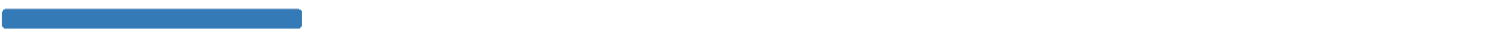

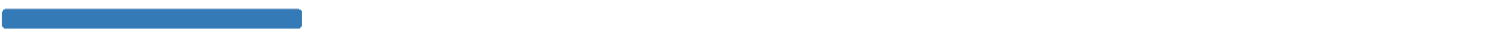

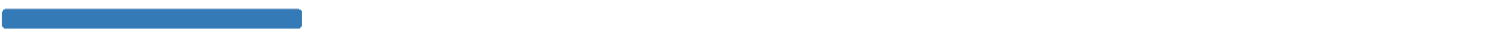

In [53]:
f = FloatProgress(min=0, max=len(combis))
display(f)

In [54]:
# this takes ages --> all pairwise comparisons
for pair in combis:
    distmat.loc[pair[0],pair[1]] = distmat.loc[pair[1],pair[0]] = ratio(*pair)
    f.value+=1

In [55]:
# let's better save this, so that we don't have to do this again
distmat.to_csv('../results/businessNames_distmat.csv')

In [69]:
distmat = 1-distmat.fillna(1)

/gpfs01/home/ggayq/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


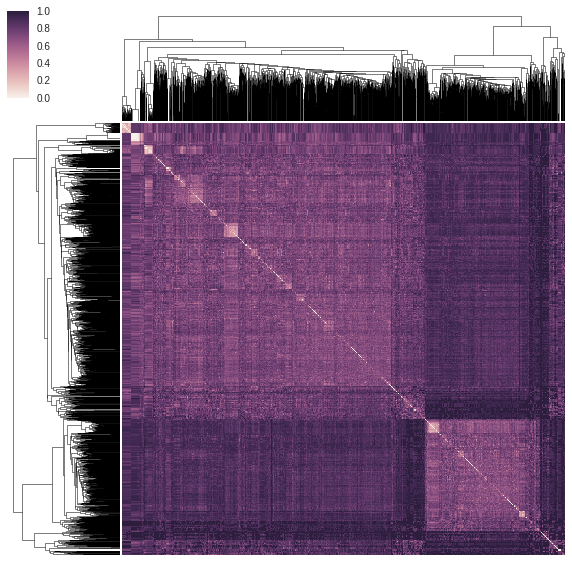

In [70]:
sns.clustermap(distmat, xticklabels=False, yticklabels=False)

In [71]:
import scipy.spatial.distance as ssd

In [72]:
# convert the redundant n*n square matrix form into a condensed nC2 array
distarr = ssd.squareform(distmat)

In [73]:
import scipy.cluster.hierarchy as sch

In [87]:
distarr

array([ 0.76744186,  0.65853659,  0.82352941, ...,  0.        ,
        0.9047619 ,  0.9047619 ])

In [74]:
linkage = sch.average(distarr)

In [125]:
cutree = sch.cut_tree(linkage, height = 0.5)
clustering = pd.DataFrame({'cluster':list(pd.np.ndarray.flatten(cutree)), 'restaurant_name':restaurantlist})
clustering = clustering.merge(pd.DataFrame(clustering.groupby('cluster').apply(len), columns = ['clustersize']).reset_index(), on = 'cluster')
clustering = clustering.sort_values('clustersize', ascending = False)

In [126]:
def join_names(data):
    print(data.restaurant_name.tolist())

In [130]:
clustering.loc[clustering.restaurant_name.str.contains('arbucks'),:]

,cluster,restaurant_name,clustersize
1121,324,Starbucks Coffee # 7531,45
1128,324,Starbucks Coffee # 801,45
1127,324,Starbucks Coffee # 7805,45
1126,324,Starbucks Coffee # 7804,45
1125,324,Starbucks Coffee # 7652,45
1124,324,Starbucks Coffee # 7564,45
1123,324,Starbucks Coffee # 7544,45
1122,324,Starbucks Coffee # 7535,45
1138,324,Starbucks Coffee Co.,45
1120,324,Starbucks Coffee # 7234,45


In [127]:
clustering.query('clustersize > 1').groupby('cluster').apply(lambda x: ';'.join(x.restaurant_name.tolist()))

cluster
2      Cuong's Vegan Sandwiches;Earl of Sandwich;Back...
7      B Good Burger;Tasty Burger.;Tasty Burger;Tasty...
8      Clay Pot Cafe;Cookin Cafe;Club Cafe;Jook Sing ...
10              W Boston Library Bar;75 On Liberty Wharf
11          Brandy Petes;89 Broad Street;Broadway Pastry
14                           CHICKEN LOU'S;ABE & LOUIE'S
16     Sate Grill;Saltie Girl;Cactus Grill;Aceituna G...
19     FISHER COLLEGE;SIMMONS COLLEGE-THE FENS;AFC SU...
20     Emirates Lounge;Emerald Lounge;Bar Louie;Air F...
22                                   EL CHALAN;AL CAPONE
23     RISTORANTE FIORE;UMBRIA RISTORANTE;TERRAMIA RI...
24     CALIFORNIA PIZZA KITCHEN;ORINOCO:A LATIN KITCH...
25     HILTON GARDEN INN EAST BOSTON;HARVARD CLUB OF ...
26                                           Amici;Alibi
27     All Star Pizza Bar;Blaze Fast Fired Pizza;Blaz...
28     Aloft Seaport Hotel -WXYZ Bar;Aloft Seaport Ho...
29                South St. Diner;Al's South St. Express
30     SUFFOLK UNIVERSI

In [33]:
tobecorr = restaurants.loc[restaurants.businessName.str.contains('hipotle')].businessName.tolist()

In [42]:
print('\n'.join(tobecorr))

Chipotle Mexican Grill
Chipotle Mexican Grill
Chipotle Mexican Grill
Chipotle Mexican Grill
Chipotle Mexican Grill
Chipotle Mexican Grill #1520
Chipotle Mexican Grille


In [40]:
for ele in tobecorr:
    b = TextBlob(ele)
    print(b.correct())

Chipotle Mexican Drill
Chipotle Mexican Drill
Chipotle Mexican Drill
Chipotle Mexican Drill
Chipotle Mexican Drill
Chipotle Mexican Drill #1520
Chipotle Mexican Rifle


In [13]:
restaurants.drop_duplicates(['Address','businessName']).businessName.value_counts()

Dunkin Donuts                    43
Subway                           33
Dunkin' Donuts                   23
Mcdonalds                        21
Burger King                      18
Au Bon Pain                      15
Domino's Pizza                   15
McDonald's                       14
Starbucks Coffee                 11
Boloco                            9
Qdoba Mexican Grill               8
Cosi                              7
Panera Bread                      7
Sweetgreen                        7
Caffe Nero                        7
The Upper Crust                   6
DUNKIN DONUTS'                    6
Rebecca's Cafe                    6
Pret A Manger                     6
Quiznos Sub                       6
PAPA JOHNS PIZZA                  6
Starbucks                         5
Royal Fried Chicken               5
Cold Stone Creamery               5
JIMMY JOHN'S                      5
Chipotle Mexican Grill            5
SOUPER SALAD                      5
BRUEGGER'S BAGEL BAKERY     

# some clustering

In [10]:
from sklearn.neighbors import KernelDensity

def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [11]:
np.random.rand(10)

array([ 0.20228513,  0.03219697,  0.06132007,  0.30381636,  0.3867287 ,
        0.53879541,  0.36420305,  0.41987726,  0.19253457,  0.88960599])

In [14]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


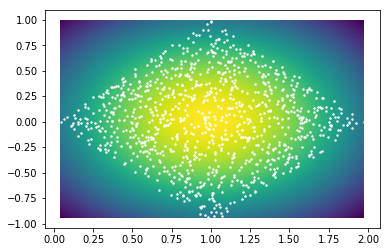

In [15]:
import numpy as np
import matplotlib.pyplot as plt

m1 = np.random.rand(1000)
m2 = np.random.rand(1000)

x, y = m1 + m2, m1 - m2

xx, yy, zz = kde2D(x, y, 1.0)

plt.pcolormesh(xx, yy, zz)
plt.scatter(x, y, s=2, facecolor='white')

In [ ]:
X = int(R) # R is the radius
for x in range(-X,X+1):
    Y = int((R*R-x*x)**0.5) # bound for y given x
    for y in range(-Y,Y+1):
        yield (x,y)

In [143]:
yelp_api = YelpAPI('N-Ib8aIm2BXOmrOBDZ6Eew', 'pD3hkJuPmLtsseWDwfmqX2l43qllLBNDbInP71Y2Fq4gCvD2JDMLsmv23MHxwbZR')

In [144]:
search_results = yelp_api.search_query(term='restaurant', location='boston')

In [145]:
total = search_results['total']

In [203]:
yelp_api.search_query(term='restaurant', location='boston', limit = 20, offset =1000)

YelpAPIError: VALIDATION_ERROR: Too many results requested, limit+offset must be <= 1000.

In [212]:
yelp_api.search_query(term='restaurant', location='boston',sort_by='rating', price = '1',limit =50, offset = 950)

{'businesses': [],
 'region': {'center': {'latitude': 42.3478416945,
   'longitude': -71.0712432861}},
 'total': 40}

In [221]:
all_business = []
for price in ["1","2","3","4"]:
    for i in range (1, 1001, 50):

        try:
            offset = i
            if offset == 951:
                offset = 950
            print(offset) 
            search_results = yelp_api.search_query(term='restaurant', location='boston',sort_by='rating', price = price,limit =50, offset = offset)
            if len(search_results['businesses'])>0:
                all_business.extend(search_results['businesses'])
        except:
            print('problem',i)

1
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
950
1
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
950
1
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
950
1
51
101
151
201
251
301
351
401
451
501
551
601
651
701
751
801
851
901
950


In [223]:
yelp_data = pd.DataFrame(all_business)

In [226]:
yelp_data.to_csv('../data/yelp_reviews.txt', sep='t')

In [216]:
yelp_data.rating.sort_values()

133    0.0
578    1.0
577    1.0
545    1.5
195    2.0
537    2.5
175    3.0
539    3.0
538    3.0
536    3.0
181    3.0
533    3.0
532    3.0
531    3.0
530    3.0
528    3.0
526    3.0
525    3.0
183    3.0
520    3.0
389    3.0
518    3.0
512    3.0
165    3.0
177    3.0
377    3.0
170    3.0
522    3.0
523    3.0
392    3.0
      ... 
415    4.5
172    4.5
413    4.5
397    4.5
398    4.5
399    4.5
486    4.5
400    4.5
401    4.5
414    4.5
402    4.5
405    4.5
187    4.5
411    4.5
180    4.5
404    4.5
92     4.5
268    5.0
574    5.0
3      5.0
167    5.0
97     5.0
129    5.0
17     5.0
55     5.0
54     5.0
168    5.0
387    5.0
570    5.0
0      5.0
Name: rating, Length: 580, dtype: float64

In [201]:
len(set(yelp_data.name.tolist()).intersection(restaurants.businessname.unique()))

230

# ranking using lineup

In [159]:
collect = []
for i in range(20):
    collect.append({'crime':random.randint(0,100), 'hygiene':random.random(), 'rating':random.randint(0,5)})
data = pd.DataFrame(collect)

In [160]:
from IPython.display import Javascript
#runs arbitrary javascript, client-side
Javascript("""
           window.datatable={};
           """.format(data.to_json(orient='records')))

<IPython.core.display.Javascript object>

In [170]:
%%javascript
element.append("<div id = 'lineuptable'></div>")
require(['./LineUpJS_bundle.min.js'],function(LineUpJS){

    const arr = window.datatable
    const desc = [
              {label: 'crime', type: 'number', column: 'crime', 'domain': [0, 100]},
             {label: 'hygiene', type: 'number', column: 'hygiene', 'domain': [0, 1]},
             {label: 'rating', type: 'number', column: 'rating', 'domain': [0, 5]}]

    var colors = d3.scale.category10();
    desc.forEach(function (d, i) {
      d.color = colors('' + i);
    });
    
    const p = new LineUpJS.provider.LocalDataProvider(arr, desc);    
     {
      const r = p.pushRanking();
          r.push((function () {
        const rstack = p.create(LineUpJS.model.createStackDesc('Stack'));
        rstack.push(p.create(desc[0]));
        rstack.push(p.create(desc[1]));
        rstack.push(p.create(desc[2]));
        rstack.setWeights([1, 1, 1]);
        return rstack;
      })());
    
    }
    const instance = LineUpJS.create(p, document.getElementById('lineuptable'), {
     
    });
    instance.update();
});


<IPython.core.display.Javascript object>

In [100]:
import os

In [103]:
from folium.plugins import MarkerCluster

m = folium.Map(location=locations,tiles='Cartodb Positron', zoom_start=1)

m.add_child(MarkerCluster(locations=locations))

m.save('1000_MarkerCluster.html')

m